# Notebook 20: Computing the integrated galaxy-wide IMF as a function of the SFR and of [Fe/H]

Computing the IGIMF involves solving for a few parameters that are ultimately determined by the physical characteristics of the galaxy over which the IMF is being integrated. This notebook is dedicated to showing off the main steps of this computation. As of now, it does not employ the exact same code as in the may source code, but the step-by-step is essentially the same.

## Prelude

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.constants as ct
import astropy.units as u
import warnings
from scipy.optimize import fsolve
from scipy.integrate import quad

In [2]:
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Stellar IMF

The stellar IMF describes the mass distribution of forming stars within a single star-forming region of the galaxy, which we call an **embedded cluster** (ECL) or **correlated star formation event** (CSFE).

#### Local IMF

The `Star` class implements the IMF within an ECL with a given mass `Mecl` and [Fe/H] metallicity `FeH`.

In [3]:
class Star():
    
    def __init__(self, FeH, Mecl):
        self.FeH = FeH
        self.Mecl = Mecl
        self.Mecl_min = 5
        self.Mmin = 0.08
        self.Mmax = None
        self._initial_guesses = None
        self._a1 = None
        self._a2 = None
        self._a3 = None
        self._afac = None
        self._x = None
        self.k1 = None
        self.k2 = None
        self.k3 = None   
        self._g1 = None
        self._g2 = None

    @property
    def x(self):
        if self._x is None:
            self._x = -0.14*self.FeH + 0.6*np.log10(self.Mecl/1e6) + 2.83
        return self._x
    
    @property
    def a1(self):
        if self._a1 is None:
            alpha1c = 1.3
            delta = 0.5
            self._a1 = alpha1c + delta * self.FeH
        return self._a1
    
    @property    
    def a2(self):
        if self._a2 is None:
            alpha2c = 2.3
            delta = 0.5
            self._a2 = alpha2c + delta * self.FeH
        return self._a2
    
    @property
    def a3(self):
        if self._a3 is None:
            if self.x < -0.87:
                self._a3 = 2.3
            elif self.x <= 1.94/0.41:
                self._a3 =-0.41*self.x + 1.94
            else:
                self._a3 = 0
        return self._a3
    
    @property
    def afac(self):
        if self._afac is None:
            self._afac = 2**(self.a1-self.a2)
        return self._afac    
    
    @property
    def g1(self):
        if self._g1 is None:
            self._g1 = self.h2(self.a1, self.Mmin, 0.5)
        return self._g1
    
    @property
    def g2(self):
        if self._g2 is None:
            self._g2 = self.h2(self.a2, 0.5, 1)
        return self._g2
            
    def h1(self, a, M1, M2):
        if a == 1:
            return np.log(M2/M1)
        else:
            return M2**(1-a)/(1-a) - M1**(1-a)/(1-a)
    
    def h2(self, a, M1, M2):
        if a == 2:
            return np.log(M2/M1)
        else:
            return M2**(2-a)/(2-a) - M1**(2-a)/(2-a)
        
    def f1(self, k1, Mmax):
        return 1 - self.afac*k1*self.h1(self.a3, Mmax, 150)
    
    def f2(self, k1, Mmax):
        g3 = self.h2(self.a3, 1, Mmax)
        return self.Mecl - k1 * (g3 + self.afac*(self.g1 + self.g2) )
    
    def constraints(self, vec):
        k1, Mmax = vec
        if k1<0 or Mmax<0:
            return (np.infty, np.infty)
        f1 = self.f1(k1, Mmax)
        f2 = self.f2(k1, Mmax)
        return (f1, f2)    
    
    def initial_guesses(self):
        norm = 10**(int(np.log10(self.Mecl))//2)
        k1 = 2**(1-self.a1)*self.Mecl/norm
        if self.a3 == 0:
            Mmax = 150
        else:
            Mmax = min(150, max(0.08, k1**(1/self.a3)))
        return (k1, Mmax)
            
    def get_Mmax_k1(self):
        if self.Mecl < self.Mecl_min:
            self.Mmax = 0
            self.k1 = 0
            self.set_k2_k3()
        else:
            self.k1, self.Mmax = fsolve(self.constraints, self.initial_guesses())
    
    def set_k2_k3(self):
        self.k2 = self.afac*self.k1
        self.k3 = self.k2
    
    def IMF(self, M):
        if self.Mmax is None:
            print('Please run get_Mmax_k first.')
            return
        if M <= self.Mmin:
            return 0
        elif M < 0.5:
            return self.k1 * M**-self.a1
        elif M < 1:
            return self.k2 * M**-self.a2
        elif M < self.Mmax:
            return self.k3 * M**-self.a3
        else:
            return 0

Initializing an instance of the class is as simple as can be, but we try to use it to compute the IMF right away, we will be warned that two parameters need to determined first, by calling the method `get_Mmax_k1`.

In [4]:
stellar_imf_feh = 0
stellar_imf_mecl = 1e4
stellar_imf = Star(stellar_imf_feh, stellar_imf_mecl)

In [5]:
stellar_imf.IMF(1)

Please run get_Mmax_k first.


The stellar IMF employed here is a multi-power law divided between the regions $0.08<M_\ast/M_\odot\leq0.5$, $0.5<M_\ast/M_\odot\leq1$ and $1<M_\ast/M_\odot<M_\mathrm{max}$, with respective indexes `a1`, `a2`, `a3` and normalization constants `k1`, `k2` and `k3`. The indexes are given analitically as functions of `FeH` and `Mecl`, and two of the normalization constants can be determined by continuity. The remaining `k` and `Mmax` need to be solved numerically for each `FeH`,`Mecl` pair, which is done by `get_Mmax_k1`.

In [6]:
stellar_imf.get_Mmax_k1()
stellar_imf.set_k2_k3()

In [7]:
stellar_imf.k1, stellar_imf.k2, stellar_imf.k3, stellar_imf.Mmax

(197.51595551618288, 98.75797775809147, 98.75797775809147, 144.21987230802117)

Let's have a look at the result.

In [8]:
stellar_imf_masses = np.logspace(-1.3, 2.3, 100)
stellar_imfs = [stellar_imf.IMF(mass) for mass in stellar_imf_masses]

Text(0.5, 1.0, 'Stellar IMF for [Fe/H] = 0 and $M_\\mathrm{ecl} = 10^4\\,\\mathrm{M}_\\odot$')

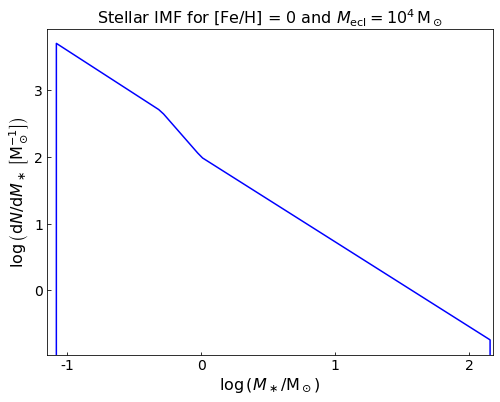

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(stellar_imf_masses, stellar_imfs, 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.07, 150)

ax.set_yticks([10**x for x in np.arange(0, 4, 1)])
ax.set_yticklabels([x for x in np.arange(0, 4, 1)])
ax.set_yticks([], minor=True)
ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
ax.set_xticks([], minor=True)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

ax.set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)
ax.set_title(f'Stellar IMF for [Fe/H] = {stellar_imf_feh} and $M_\mathrm{{ecl}} = 10^{np.log10(stellar_imf_mecl):.0f}\,\mathrm{{M}}_\odot$', fontsize=16)

#### Testing the stellar IMF for problematic regions

A broader test will now allow us to see the full range of parameters available to the `Star` class.

In [10]:
stellar_imf_logmecls = np.linspace(0.7, 9, 10)

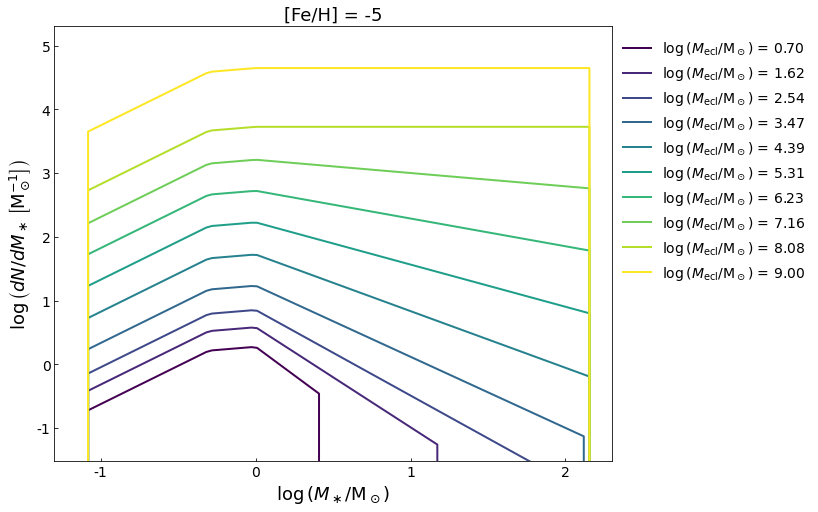

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
stellar_imf_feh = -5
cnorm = stellar_imf_logmecls.max() - stellar_imf_logmecls.min()

for logmecl in stellar_imf_logmecls:
    mecl = 10**logmecl
    test_stellar = Star(stellar_imf_feh, mecl)
    test_stellar.get_Mmax_k1()
    test_stellar.set_k2_k3()
    
    test_stellar_masses = np.logspace(-1.3, 2.3, 100)
    test_stellar_IMFs = [test_stellar.IMF(mass) for mass in test_stellar_masses]

    color = cm.viridis((logmecl-stellar_imf_logmecls.min())/cnorm)
    ax.plot(test_stellar_masses, test_stellar_IMFs, '-', c=color, label=r'$\log\left(M_\mathrm{ecl}/\mathrm{M}_\odot\right)$'+f' = {logmecl:.2f}', lw=2)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(5e-2, 2e2)
ax.set_ylim(3e-2, 2e5)

ax.set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)
ax.set_ylabel(r'$\log\left(dN/dM_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=18)
ax.set_title(f'[Fe/H] = {stellar_imf_feh }', fontsize=18)
ax.legend(loc=(1.01,0.4), frameon=False, fontsize=14)

ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
ax.set_xticks([], minor=True)
ax.set_yticks([10.**x for x in np.arange(-1, 6, 1)])
ax.set_yticklabels([x for x in np.arange(-1, 6, 1)])
ax.set_yticks([], minor=True)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

In [12]:
stellar_imf_test_fehs = [-4, -3, -2, -1, 0, 1]

Text(0.05, 0.37, '$\\log\\left(dN/dM_\\ast\\,\\left[\\mathrm{M}_\\odot^{-1}\\right]\\right)$')

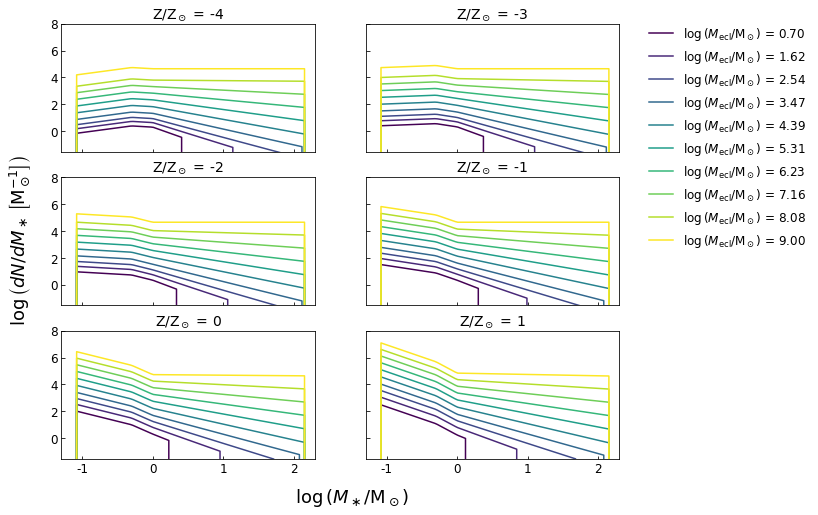

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10,8), sharex='col', sharey='row')
cnorm = stellar_imf_logmecls.max() - stellar_imf_logmecls.min()

i = 0
j = -1
for feh in stellar_imf_test_fehs:
    j += 1
    for logmecl in stellar_imf_logmecls:
        mecl = 10**logmecl
        test_stellar = Star(feh, mecl)
        test_stellar.get_Mmax_k1()
        test_stellar.set_k2_k3()
    
        test_stellar_masses = np.logspace(-1.3, 2.3, 100)
        test_stellar_imfs = [test_stellar.IMF(mass) for mass in test_stellar_masses]
        
        color = cm.viridis((logmecl-stellar_imf_logmecls.min())/cnorm)
        axes[i,j].plot(test_stellar_masses, test_stellar_imfs, '-', c=color, label=r'$\log\left(M_\mathrm{ecl}/\mathrm{M}_\odot\right)$'+f' = {logmecl:.2f}')
        axes[i,j].set_title(f'Z/Z$_\odot$ = {feh}', fontsize=14)
    if j == 1:
        j = -1
        i += 1
    
for axs in axes:
    for ax in axs:
        ax.set_xscale('log')
        ax.set_yscale('log')       
        ax.set_xlim(0.05, 200)
        ax.set_ylim(3e-2, 1e8)
        ax.set_yticks([10**x for x in np.arange(0, 10, 2)])
        ax.set_yticklabels([x for x in np.arange(0, 10, 2)])
        ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
        ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
        ax.set_xticks([], minor=True)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
        
axes[0,1].legend(loc=(1.1,-0.8), frameon=False, fontsize=12)
fig.text(0.45, 0.05, r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)   
fig.text(0.05, 0.37, r'$\log\left(dN/dM_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', rotation=90, fontsize=18)

## Embedded cluster IMF

The ECL IMF describes the mass distribution of embedded clusters within a galaxy.

#### ECL IMF

The `EmbeddedCluster` class implements the IMF within a galaxy with a given star formation rate `SFR` and star formation period `time`.

In [14]:
class EmbeddedCluster():
    
    def __init__(self, SFR, time):
        self.SFR = SFR
        self.time = time
        self.Mtot = SFR*time
        self.k = None
        self.Mmin = 5
        self.Mmax = None
        self._beta = None
        self._g0 = None
        self._g1 = None
        self._g2 = None
        
    @property
    def beta(self):
        if self._beta is None:
            self._beta = -0.106*np.log10(self.SFR) + 2
        return self._beta
    
    def h0(self, M1, M2):
        return M1**(2-self.beta) + (2-self.beta)/(1-self.beta) * self.Mtot * M2**(1-self.beta)
    
    @property
    def g0(self):
        if self._g0 is None:
            self._g0 = self.h0(self.Mmin, 1e9)
        return self._g0
    
    def h1(self, M1, M2):
        return M1 + self.Mtot*np.log(M2)
    
    @property
    def g1(self):
        if self._g1 is None:
            self._g1 = self.h1(self.Mmin, 1e9)
        return self._g1
    
    def h2(self, M1, M2):
        return np.log(M1) - self.Mtot/M2
    
    @property
    def g2(self):
        if self._g2 is None:
            self._g2 = self.h2(self.Mmin, 1e9)
        return self._g2
        
    def f0(self, Mmax):
        return self.h0(Mmax, Mmax) - self.g0
    
    def f1(self, Mmax):
        return self.h1(Mmax, Mmax) - self.g1
    
    def f2(self, Mmax):
        return self.h2(Mmax, Mmax) - self.g2
    
    def initial_guess(self):
        return min(1e9, 1e6*self.SFR)
    
    def constraints(self, Mmax):
        if Mmax<0:
            return np.infty
        
        if self.beta == 2:
            return self.f2(Mmax)
        elif self.beta == 1:
            return self.f1(Mmax)
        else:
            return self.f0(Mmax)      
    
    def _get_Mmax(self):
        [self.Mmax] = fsolve(self.constraints, self.initial_guess())

    def _get_k(self):
        if self.beta == 2:
            self.k = 1/(1/self.Mmax - 1e-9)
        elif self.beta == 1:
            self.k = self.Mtot / (self.Mmax - self.Mmin)
        else:
            a = 1-self.beta
            self.k = a / (1e9**a - self.Mmax**a)
    
    def get_Mmax_k(self):
        self._get_Mmax()
        self._get_k()
        
    def IMF(self, Mecl):
        if Mecl <= self.Mmin:
            return 0
        elif Mecl < self.Mmax:
            return self.k*Mecl**-self.beta
        else:
            return 0   

This class is build in an analogous way to the `Star` class. The ECL IMF is a simple power law, with normalization constant `k` and upper limit `Mmax` that also have to be determined for each galaxy, through method `get_Mmax_k`.

In [15]:
ecl_imf_sfr = 10
ecl_imf_time = 1e7
ecl = EmbeddedCluster(ecl_imf_sfr, ecl_imf_time)
ecl.get_Mmax_k()

In [16]:
ecl.k, ecl.Mmax

(2324218.6109898263, 14598830.867197853)

Let's have a look at the result.

In [17]:
ecl_imf_masses = np.logspace(0, 9, 100)
ecl_imfs = [ecl.IMF(mass) for mass in ecl_imf_masses]

Text(0.5, 1.0, 'ECIMF for SFR = 10 $\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$ and $\\Delta t$ = 0.01 Gyr')

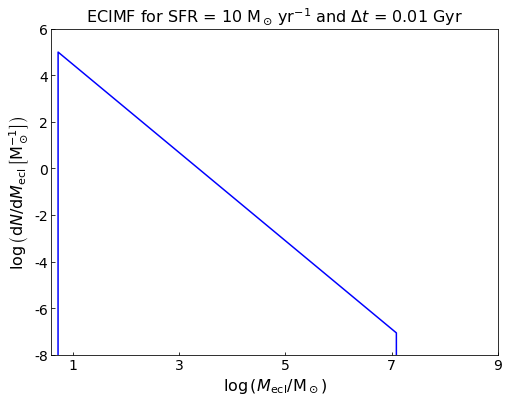

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(ecl_imf_masses, ecl_imfs, 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(4, 1e9)

ax.set_yticks([10.**x for x in np.arange(-8, 8, 2)])
ax.set_yticklabels([x for x in np.arange(-8, 8, 2)])
ax.set_xticks([10.**x for x in np.arange(1, 11, 2)])
ax.set_xticklabels([x for x in np.arange(1, 11, 2)])
ax.set_xticks([], minor=True)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

ax.set_xlabel(r'$\log\left(M_\mathrm{ecl}/\mathrm{M}_\odot\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\mathrm{ecl}\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)
ax.set_title(f'ECIMF for SFR = {ecl_imf_sfr} $\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$ and $\Delta t$ = {ecl_imf_time/1e9} Gyr', fontsize=16)

#### Testing the cluster IMF for problematic regions

A broader test will now allow us to see the full range of parameters available to the `Star` class.

In [19]:
ecl_imf_logsfrs = np.linspace(-5, 4, 10)

In [20]:
time = 1e7

test_ecl_imfs = []
for logsfr in ecl_imf_logsfrs:
    sfr = 10**logsfr
    test_ecl = EmbeddedCluster(sfr, time)
    test_ecl.get_Mmax_k()
    test_ecl_imfs.append([test_ecl.IMF(mass) for mass in ecl_imf_masses])

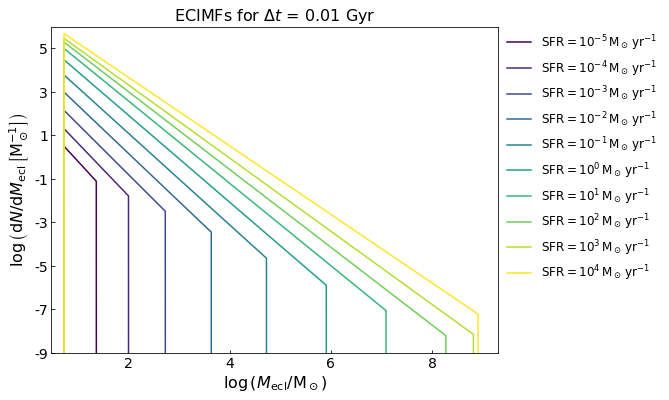

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
cnorm = ecl_imf_logsfrs.max() - ecl_imf_logsfrs.min()

for logsfr, test_ecl_imf in zip(ecl_imf_logsfrs, test_ecl_imfs):
    color = cm.viridis((logsfr-ecl_imf_logsfrs.min())/cnorm)
    ax.plot(ecl_imf_masses, test_ecl_imf, '-', c=color, label=r'$\mathrm{SFR} = 10^{%.0f}\,\mathrm{M}_\odot\,\mathrm{yr}^{-1}$' % logsfr)    
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(3e0, 2e9)
ax.set_ylim(1e-9, 1e6)

ax.set_xticks([10.**x for x in np.arange(2, 10, 2)])
ax.set_xticklabels([x for x in np.arange(2, 10, 2)])
ax.set_yticks([10.**x for x in np.arange(-9, 7, 2)])
ax.set_yticklabels([x for x in np.arange(-9, 7, 2)])
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

ax.set_xlabel(r'$\log\left(M_\mathrm{ecl}/\mathrm{M}_\odot\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\mathrm{ecl}\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)
ax.set_title(f'ECIMFs for $\Delta t$ = {time/1e9} Gyr', fontsize=16)
ax.legend(loc=(1.01, 0.2), frameon=False, fontsize=12)

## Integrated galaxy-wide IMF (IGIMF)

Finally, the IGIMF is obtained by integrating the ECL IMF times the stellar IMF over the whold galaxy (that is, over `Mecl`).

#### IGIMF

The `Galaxy` class implements the numerical integration of the IMFs for the IGIMF of a galaxy with a given `SFR` and `FeH`.

In [22]:
class Galaxy():
    
    def __init__(self, SFR, FeH):
        self.SFR = SFR
        self.FeH = FeH
        self.time = 1e7 #yr
        self.clusters = None
        self.Mecl_max = None
        self.Mecl_min = 5
        
    def get_clusters(self):
        self.clusters = EmbeddedCluster(self.SFR, self.time)
        self.clusters.get_Mmax_k()
        self.Mecl_max = self.clusters.Mmax
    
    def get_stars(self, Mecl, m):
        stellar = Star(self.FeH, Mecl)
        stellar.get_Mmax_k1()
        stellar.set_k2_k3()
        return stellar.IMF(m)

    def integrand(self, Mecl, m):
        if Mecl > self.Mecl_max:
            return 0
        IMF_stellar = self.get_stars(Mecl, m)
        IMF_cluster = self.clusters.IMF(Mecl)
        return IMF_stellar*IMF_cluster
    
    def IMF(self, m):
        IMF = quad(self.integrand, self.Mecl_min, self.Mecl_max, args=(m))
        return IMF

Once the glass is instantiated, we only need to generate the galaxy's ECL IMF through the `get_clusters` method before calling the `IMF` method for any desired stellar mass `m`, which will compute the gwIMF as a IGIMF at that mass.

In [23]:
igimf_sfr = 10
igimf_feh = 0
galaxy = Galaxy(igimf_sfr, igimf_feh)

In [24]:
galaxy.get_clusters()

Let's have a look at the results. It's best not to compute the gwIMF at too many mass values because the numerical integration step makes the `Galaxy` class much slower than either the `Star` or `EmbeddedCluster` classes.

In [25]:
igimf_masses = np.logspace(np.log10(0.08), np.log10(150), 20)
igimfs = np.array([galaxy.IMF(mass) for mass in igimf_masses])

Text(0.5, 1.0, 'IGIMF for SFR = 1.0 $\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$ and [Fe/H] = 0')

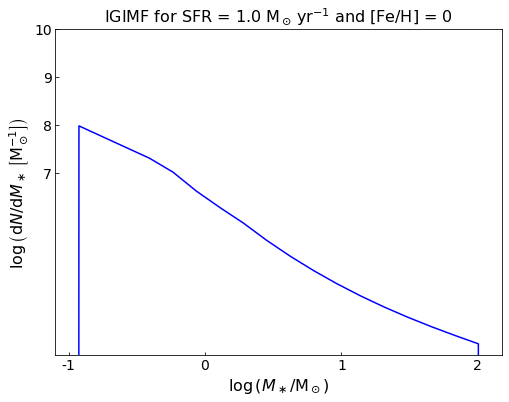

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(igimf_masses, igimfs[:, 0], 'b-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.08, 150)

ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
ax.set_xticks([], minor=True)
ax.set_yticks([10.**x for x in np.arange(7, 11, 1)])
ax.set_yticklabels([x for x in np.arange(7, 11, 1)])
ax.set_yticks([], minor=True)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

ax.set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)
ax.set_title(f'IGIMF for SFR = {np.log10(igimf_sfr)} $\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$ and [Fe/H] = {igimf_feh}', fontsize=16)

#### Testing the IGIMF for variations in metallicity

As before, we should check the results for the full range of parameters available to the `IGIMF` class.

In [27]:
igimf_fehs = np.arange(-3, 2, 1)
igimf_masses2 = np.logspace(np.log10(0.08), np.log10(149), 10)

In [28]:
test_igimfs = []

for feh in igimf_fehs:
    galaxy = Galaxy(igimf_sfr, feh)
    galaxy.get_clusters()
    test_igimfs.append(np.array([galaxy.IMF(mass) for mass in igimf_masses2]))

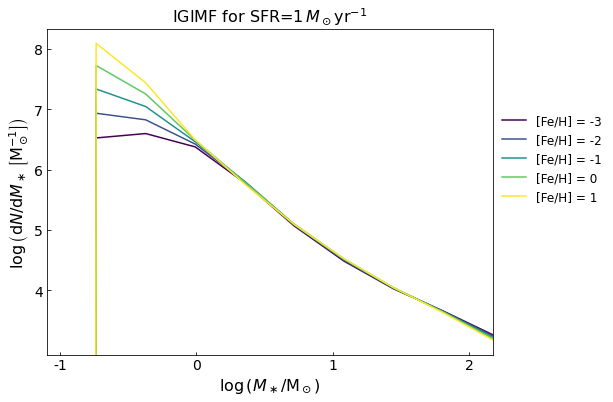

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
cnorm = igimf_fehs.max() - igimf_fehs.min()

for feh, igimfs in zip(igimf_fehs, test_igimfs):
    color = cm.viridis((feh-igimf_fehs.min())/cnorm)
    ax.plot(igimf_masses2, igimfs[:,0], '-', c=color, label=f'[Fe/H] = {feh}')
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.08, 150)

ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
ax.set_xticks([], minor=True)
ax.set_yticks([10.**x for x in np.arange(4, 9, 1)])
ax.set_yticklabels([x for x in np.arange(4, 9, 1)])
ax.set_yticks([], minor=True)
ax.tick_params(axis='both', which='both', direction='in', labelsize=14)

ax.set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=16)
ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)
ax.set_title('IGIMF for SFR='+r'$1\,M_\odot\mathrm{yr}^{-1}$', fontsize=16)
ax.legend(loc=(1.01, 0.45), frameon=False, fontsize=12)

#### Testing the IGIMF for variations in metallicity and SFR

In [30]:
igimf_logsfrs = np.arange(-2, 4, 1)

In [31]:
test2_igimfs = []

for logsfr in igimf_logsfrs:
    sfr = 10.**logsfr
    igimf_array = np.empty((0,igimf_masses2.shape[0]), np.float64)
    for feh in igimf_fehs:
        print(f'Now computing IGIMF for logsfr = {logsfr} and feh = {feh}')
        galaxy = Galaxy(sfr, feh)
        galaxy.get_clusters()
        igimf = np.array([[galaxy.IMF(mass)[0] for mass in igimf_masses2]])
        igimf_array = np.append(igimf_array, igimf, axis=0)
    test2_igimfs.append(igimf_array)

Now computing IGIMF for logsfr = -2 and feh = -3
Now computing IGIMF for logsfr = -2 and feh = -2
Now computing IGIMF for logsfr = -2 and feh = -1
Now computing IGIMF for logsfr = -2 and feh = 0
Now computing IGIMF for logsfr = -2 and feh = 1
Now computing IGIMF for logsfr = -1 and feh = -3
Now computing IGIMF for logsfr = -1 and feh = -2
Now computing IGIMF for logsfr = -1 and feh = -1
Now computing IGIMF for logsfr = -1 and feh = 0
Now computing IGIMF for logsfr = -1 and feh = 1
Now computing IGIMF for logsfr = 0 and feh = -3
Now computing IGIMF for logsfr = 0 and feh = -2
Now computing IGIMF for logsfr = 0 and feh = -1
Now computing IGIMF for logsfr = 0 and feh = 0
Now computing IGIMF for logsfr = 0 and feh = 1
Now computing IGIMF for logsfr = 1 and feh = -3
Now computing IGIMF for logsfr = 1 and feh = -2
Now computing IGIMF for logsfr = 1 and feh = -1
Now computing IGIMF for logsfr = 1 and feh = 0
Now computing IGIMF for logsfr = 1 and feh = 1
Now computing IGIMF for logsfr = 2 and

/tmp/ipykernel_70068/3391918021.py:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  IMF = quad(self.integrand, self.Mecl_min, self.Mecl_max, args=(m))


Now computing IGIMF for logsfr = 2 and feh = -2


/tmp/ipykernel_70068/3391918021.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  IMF = quad(self.integrand, self.Mecl_min, self.Mecl_max, args=(m))


Now computing IGIMF for logsfr = 2 and feh = -1
Now computing IGIMF for logsfr = 2 and feh = 0
Now computing IGIMF for logsfr = 2 and feh = 1
Now computing IGIMF for logsfr = 3 and feh = -3


/tmp/ipykernel_70068/183282996.py:105: RuntimeWarning: overflow encountered in double_scalars
  Mmax = min(150, max(0.08, k1**(1/self.a3)))


Now computing IGIMF for logsfr = 3 and feh = -2
Now computing IGIMF for logsfr = 3 and feh = -1
Now computing IGIMF for logsfr = 3 and feh = 0
Now computing IGIMF for logsfr = 3 and feh = 1


Text(0.05, 0.37, '$\\log\\left(dN/dM_\\ast\\,\\left[\\mathrm{M}_\\odot^{-1}\\right]\\right)$')

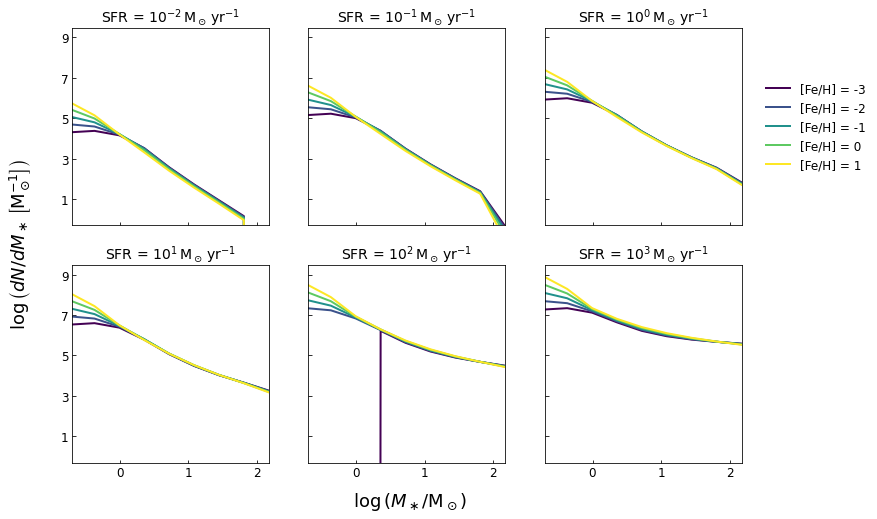

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), sharex='col', sharey='row')
axs = axes.flatten()
cnorm = igimf_fehs.max() - igimf_fehs.min()

i = 0
for ax, logsfr, igimfs in zip(axs, igimf_logsfrs, test2_igimfs):
    for igimf, feh in zip(igimfs, igimf_fehs):
        color = cm.viridis((feh - igimf_fehs.min())/cnorm)
        ax.plot(igimf_masses2, igimf, '-', c=color, label=f'[Fe/H] = {feh}', lw=2)
    ax.set_title(f'SFR = $10^{{{logsfr}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', fontsize=14)
    if i == 2:
        ax.legend(loc=(1.1, 0.25), frameon=False, fontsize=12)
    i += 1
    
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_yticks([10.**x for x in np.arange(1, 11, 2)])
    ax.set_yticklabels([x for x in np.arange(1, 11, 2)])
    ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
    
    ax.set_xlim(0.2, 150)
    ax.set_ylim(5e-1, 3e9)
    
fig.text(0.45, 0.05, r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)   
fig.text(0.05, 0.37, r'$\log\left(dN/dM_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', rotation=90, fontsize=18)

#### Reproducing the plot from Jerabkova et al. (2018)

In [33]:
j_logsfrs = [-5, 0, 4]
j_fehs = [1, 0, -3, -5]

In [34]:
j_igimfs = []

for feh in j_fehs:
    print(f'Computing IGIMFs for [Fe/H] = {feh}')
    j_igimf = []
    for logsfr in j_logsfrs:
        sfr = 10.**logsfr
        print(f'Computing IGIMF for SFR = {sfr}')
        test_galaxy = Galaxy(sfr, feh)
        test_galaxy.get_clusters()
    
        j_igimf.append([sfr, np.array([test_galaxy.IMF(mass)[0] for mass in igimf_masses])])
    j_igimfs.append([feh, j_igimf])

Computing IGIMFs for [Fe/H] = 1
Computing IGIMF for SFR = 1e-05
Computing IGIMF for SFR = 1.0
Computing IGIMF for SFR = 10000.0
Computing IGIMFs for [Fe/H] = 0
Computing IGIMF for SFR = 1e-05
Computing IGIMF for SFR = 1.0
Computing IGIMF for SFR = 10000.0
Computing IGIMFs for [Fe/H] = -3
Computing IGIMF for SFR = 1e-05
Computing IGIMF for SFR = 1.0
Computing IGIMF for SFR = 10000.0


/tmp/ipykernel_70068/183282996.py:105: RuntimeWarning: overflow encountered in double_scalars
  Mmax = min(150, max(0.08, k1**(1/self.a3)))
/tmp/ipykernel_70068/3391918021.py:30: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  IMF = quad(self.integrand, self.Mecl_min, self.Mecl_max, args=(m))


Computing IGIMFs for [Fe/H] = -5
Computing IGIMF for SFR = 1e-05
Computing IGIMF for SFR = 1.0
Computing IGIMF for SFR = 10000.0


Text(0.4, -0.03, '$\\log(M_\\ast/M_\\odot)$')

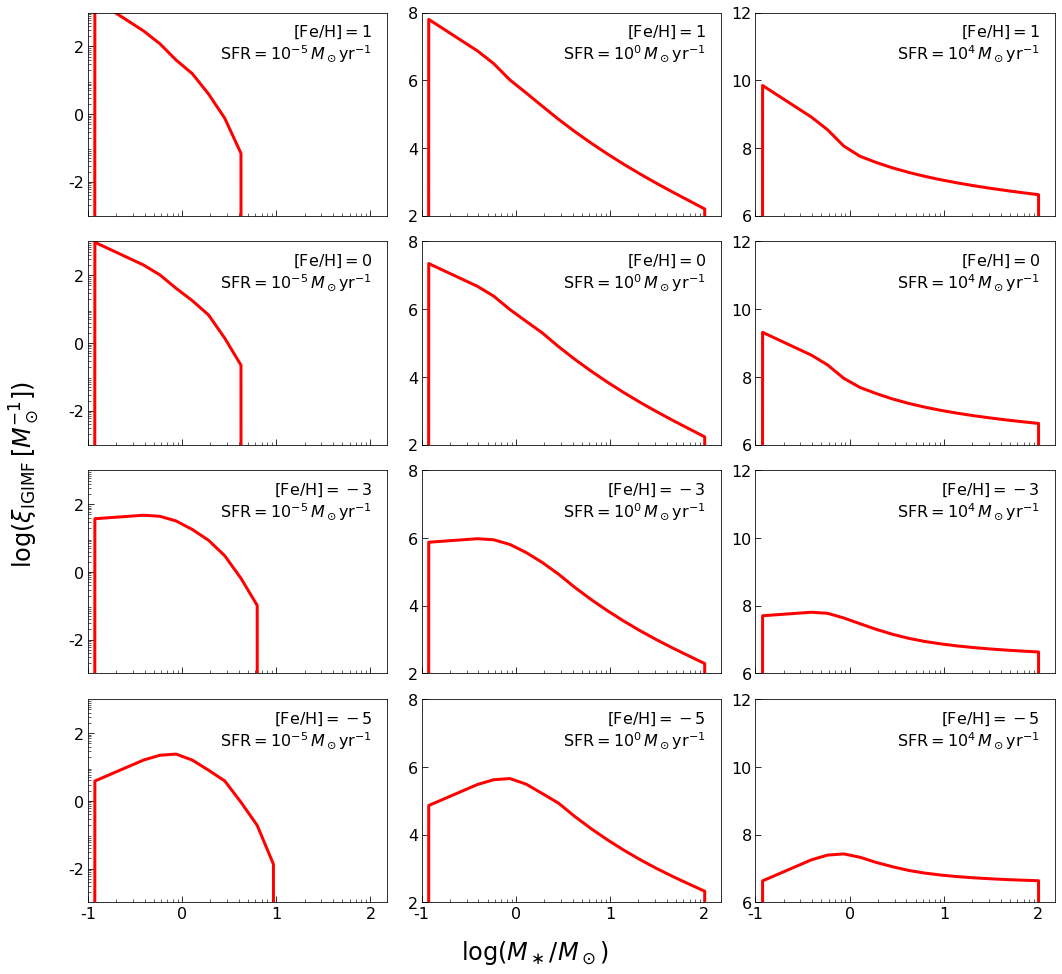

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(14,13), sharex='col', tight_layout=True)

i = 0
j = 0

for j_igimf_sfrs in j_igimfs:
    feh = j_igimf_sfrs[0]
    j = 0
    for sfr, j_igimf in j_igimf_sfrs[1]:
        axes[i,j].plot(igimf_masses, j_igimf, 'r-', lw=3)
        textstr = '\n'.join((
                            r'$\mathrm{[Fe/H]} = %.0f$' % (feh, ),
                            r'$\mathrm{SFR} = 10^{%.0f}\,M_\odot\mathrm{yr}^{-1}$' % (int(np.log10(sfr)))
                            ))
        props = dict(alpha=0)
        axes[i,j].text(0.95, 0.95, textstr, transform= axes[i,j].transAxes, fontsize=16,
        verticalalignment='top', ha='right', bbox=props)
        j += 1
    
    i += 1
    
for axs in axes:
    axs[0].set_ylim(1e-3, 1e3)
   # axs[0].tick_params
    axs[1].set_ylim(1e2, 1e8)
    axs[2].set_ylim(1e6, 1e12)
    for ax in axs:
        ax.set_xscale('log')
        ax.set_yscale('log')       
        ax.set_xlim(0.1, 150)

        
########################################################################################## 
for i in range(0,4):
    axes[i,0].set_yticks([0.01, 1, 100])
    axes[i,0].set_yticklabels(['-2', '0', '2'])
    axes[i,0].tick_params(axis='y', which='major', labelsize=16, length=6, direction='in')
    axes[i,0].tick_params(axis='y', which='minor', labelsize=14, length=3, direction='in')
    axes[i,0].tick_params(axis='x', which='major', labelsize=16, length=6, direction='in')
    axes[i,0].tick_params(axis='x', which='minor', labelsize=14, length=3, direction='in')
##########################################################################################

        
##########################################################################################  
for i in range(0,4):
    axes[i,1].set_yticks([1e2, 1e4, 1e6, 1e8])
    axes[i,1].set_yticklabels(['2', '4', '6', '8'])
    axes[i,1].tick_params(axis='y', which='major', labelsize=16, length=6, direction='in')
    axes[i,1].tick_params(axis='y', which='minor', labelsize=14, length=3, direction='in')
    axes[i,1].tick_params(axis='x', which='major', labelsize=16, length=6, direction='in')
    axes[i,1].tick_params(axis='x', which='minor', labelsize=14, length=3, direction='in')
##########################################################################################

##########################################################################################
for i in range(0,4):
    axes[i,2].set_yticks([1e6, 1e8, 1e10, 1e12])
    axes[i,2].set_yticklabels(['6', '8', '10', '12'])
    axes[i,2].tick_params(axis='y', which='major', labelsize=16, length=6, direction='in')
    axes[i,2].tick_params(axis='y', which='minor', labelsize=14, length=3, direction='in')
    axes[i,2].tick_params(axis='x', which='major', labelsize=16, length=6, direction='in')
    axes[i,2].tick_params(axis='x', which='minor', labelsize=14, length=3, direction='in')
##########################################################################################

####################################################
for i in range(0,3):
    axes[3,i].set_xticks([1e-1, 1e0, 1e1, 1e2])
    axes[3,i].set_xticklabels(['-1', '0', '1', '2'])
####################################################

fig.text(-0.05, 0.4, r'$\log(\xi_\mathrm{IGIMF}\,[M_\odot^{-1}])$', fontsize=24, rotation=90)
fig.text(0.4, -0.03, r'$\log(M_\ast/M_\odot)$', fontsize=24)